In [ ]:
%pip install google-genai
%pip install matplotlib
%pip install os
%pip install dotenv
%pip install pydantic

In [60]:
from google import genai
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv
from google.genai import types
from pydantic import BaseModel, Field


In [61]:
class FacialAnalysis(BaseModel):
    percentage: int = Field(description="Integer similarity score.")
    similarities: list[str] = Field(description="Key similarities.")
    differences: list[str] = Field(description="Key differences.")

In [62]:
def create_genai_client():
    import os

    api_key = os.getenv("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("GOOGLE_API_KEY not found in .env file")    

    # Configure the client with your API key
    client = genai.Client(api_key=api_key, http_options={'api_version': 'v1alpha'})

    return client

In [63]:
load_dotenv()

# Configure the client with your API key
client = create_genai_client()

In [64]:
def load_image(image_path: str):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [65]:
def get_inline_data_part(image_path: str):
    import mimetypes

    try:
        mime_type, _ = mimetypes.guess_type(image_path)
        if mime_type is None:
            mime_type = 'application/octet-stream'
            print(f"Warning: Could not determine MIME type for {image_path}. Defaulting to {mime_type}.")

        file_bytes: bytes | None = None
        with open(image_path, "rb") as image_file:
            file_bytes = image_file.read()
        
        if file_bytes is None:
            raise Exception(f"Unable to read the bytes from {image_path}")
    
        return types.Part(
            inline_data=types.Blob(
                mime_type=mime_type,
                data=file_bytes
            ),
            media_resolution={"level": "media_resolution_high"}
        ) 
    except FileNotFoundError:
        print (f"Error: The file was not found at {image_path}")
    except Exception as e:
        print (f"An error occurred: {e}")

In [66]:
prompt = """
Role: You are an Expert Biometric Analyst and Facial Recognition Specialist. Your expertise lies in anthropometric comparison, analyzing facial landmarks, bone structure, and morphological traits.

Task: Analyze the attached image(s). Compare the physical appearance of the two individuals shown. If two separate images are provided, treat the first as Person A and the second as Person B. If one image containing two people is provided, treat the person on the left as Person A and the person on the right as Person B.

Analysis Criteria:
Focus strictly on biological and physical traits (facial geometry, feature shapes, and proportions). Ignore clothing, lighting, camera angles, or accessories (glasses, hats) unless they obscure features.

The Rule of Similarity (Visual Scoring Rubric):
You must assign a final similarity percentage based strictly on this scale:

0% - 10% (Dissimilar): Polar opposites. No shared facial geometry or features; different phenotypes.
11% - 20% (Faint Connection): Very weak link; perhaps a shared broad head shape, but all specific features differ.
21% - 30% (Vague Resemblance): Superficial similarities only (e.g., similar eye color or hair texture only), but the faces look unrelated.
31% - 40% (Partial Overlap): Noticeable but minor similarities. Maybe the nose or mouth is similar, but the overall bone structure is different.
41% - 50% (Moderate Association): Reminiscent. One major anatomical zone aligns (e.g., eyes/brows), but the rest of the face is distinct.
51% - 60% (Balanced Similarity): Comparable. Distinct individuals, but there is enough overlap in bone structure to suggest a relation.
61% - 70% (Strong Resemblance): "Cousin" status. Strong resemblance in the "map" of the face; differences are only in the details/nuance.
71% - 80% (Kindred Spirits): High resemblance. They share facial ratios that suggest a blood relation (e.g., parent/child or first cousins), but are clearly distinguishable as different people.
81% - 90% (Biological Sibling / Doppelgänger): Extremely high correlation. This tier represents biological sisters/brothers who look very similar, or unrelated high-grade lookalikes. They share almost all facial features, with only minor structural variances.
91% - 100% (Identical Match): The same person or identical twins. Facial geometry and bone structure are exact matches. Any visible differences are strictly superficial (e.g., age, styling, or weight) and not structural.

Output Format:
Please provide the result strictly in the following format:

Similarity Score: [Insert Integer]%

Key Similarities:
- [Detail 1]
- [Detail 2]
- [Detail 3]

Key Differences:
- [Detail 1]
- [Detail 2]
- [Detail 3]
"""

In [68]:
def analyse_facial_images(person_a_image: str, person_b_image: str):
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[
            types.Content(
                parts=[
                    types.Part(text=prompt),
                    get_inline_data_part(person_a_image),
                    get_inline_data_part(person_b_image),
                ]
            )
        ],
        config=types.GenerateContentConfig(
            response_mime_type="application/json",
            response_json_schema=FacialAnalysis.model_json_schema(),
            tools=[types.Tool(
                google_search=types.GoogleSearch()
            )]
        )
    )

    # for candidate in response.candidates:
    #     for part in candidate.content.parts:
    #         if part.thought:
    #             print(part.thought)
    #         elif part.text:
    #             print(part.text)

    result = FacialAnalysis.model_validate_json(response.text)
    return result

def print_result(person_a_image: str, person_b_image: str):
    result = analyse_facial_images(person_a_image=person_a_image, person_b_image=person_b_image)

    load_image(person_a_image)
    load_image(person_b_image)
    print("Percentage: ", result.percentage)
    print ("Similarities:")
    for s in result.similarities:
        print("- ", s)

    print ("Differences:")
    for d in result.differences:
        print("-",  d)

def print_test_cases(heading: str, cases: list[list[str]]):
    print(heading)
    for case in cases:
        print_result(person_a_image=case[0], person_b_image=case[1])

Dissimilar cases


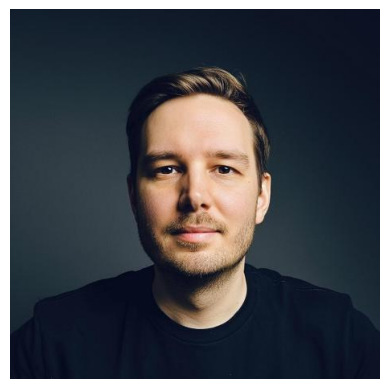

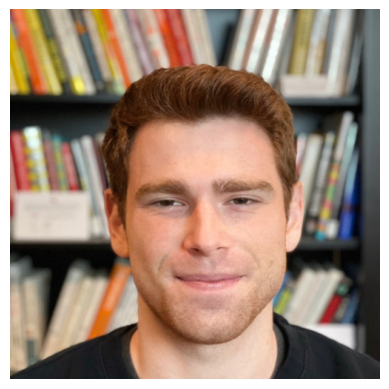

Percentage:  28
Similarities:
-  Both subjects share a similar high forehead height and general hairline recession pattern.
-  The vertical length of the nose relative to the mid-face is comparable.
-  Both individuals exhibit similar facial hair grooming styles (short stubble).
Differences:
- The jawline structure is fundamentally different; Person A has a softer, rounded/oval mandible, while Person B has a sharp, wide, and angular square jaw.
- Eye morphology is distinct; Person A has open, almond-shaped eyes, whereas Person B has deep-set, hooded eyes with a heavier brow ridge.
- Overall face shape topology differs, with Person A presenting an oblong verticality and Person B presenting a broad, square facial structure.
- Pigmentation and hair color are mismatched, with Person A being light brown/dark blonde and Person B exhibiting red/ginger traits.


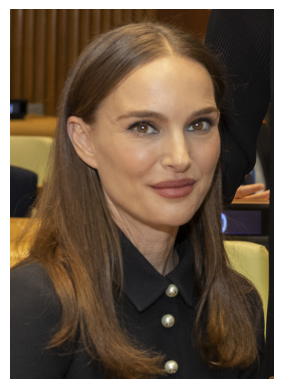

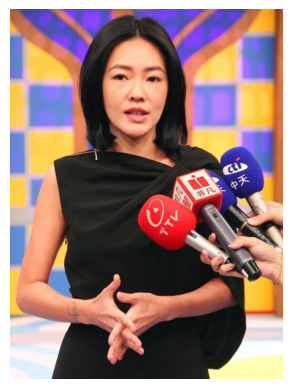

Percentage:  15
Similarities:
-  Both individuals share a similar oval face shape with a gently tapered chin.
-  There is a coincidence in overall coloring, with both possessing dark brown eyes and dark hair.
-  Both display relatively high cheekbones and general facial symmetry.
-  Lip fullness is comparable, with neither having notably thin nor overly full lips.
Differences:
- The most significant difference is the distinct ethnic phenotypes (Caucasian vs. Asian), leading to fundamental differences in underlying bone structure.
- Eye geometry is disparate; Person A has deep-set almond-shaped eyes with a visible crease, whereas Person B has a flatter upper eyelid structure typical of East Asian morphology.
- Nasal architecture differs; Person A features a narrower bridge and sharper tip, while Person B has a slightly softer, broader nasal tip.
- Brow bone definition is more prominent in Person A, creating a stronger shadow over the eyes compared to the flatter brow region of Person B.

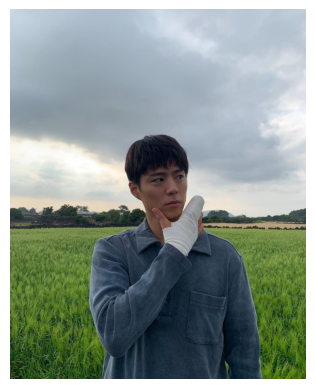

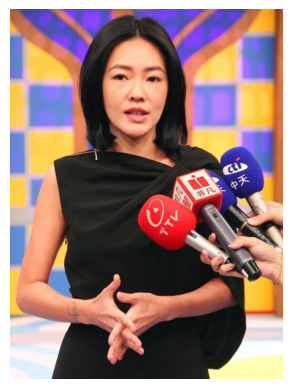

Percentage:  15
Similarities:
-  Both individuals share a general East Asian phenotype with fair skin tones and straight dark hair.
-  There is a superficial similarity in the general alignment of facial thirds (forehead to brow, brow to nose, nose to chin).
-  Both possess dark brown iris pigmentation and almond-shaped eye outlines, although the specific eye structure differs.
Differences:
- Bone structure is distinct and sexually dimorphic; Person A has a more angular, masculine jawline, whereas Person B features a softer, oval face shape with a tapered chin.
- Eye morphology differs significantly; Person A has sharper, hooded eyes (appearing monolid), while Person B has rounder eyes with distinct double eyelids.
- Nose architecture is unrelated; Person A has a higher, straighter nasal bridge and defined tip, while Person B has a slightly lower bridge and wider alae.
- Mouth shape varies noticeably; Person B has fuller, wider lips compared to Person A's relatively smaller mouth width

In [69]:
dissimilar_cases = [
    ['./images/patrick.jpg', './images/logan_kilpatrick.jpg'],
    ['./images/Natalie_Portman.jpg', './images/Little_S.jpg'],
    ['./images/park_bo_gum.jpg', './images/Little_S.jpg'],
]

print_test_cases(heading="Dissimilar cases", cases=dissimilar_cases)

In [ ]:
similar_cases = [
    ['./images/Big_S.jpg', './images/Little_S.jpg'],
    ['./images/Natalie_Portman.jpg', './images/Keira_Knightley.jpg'],
    ['./images/park_bo_gum.jpg', './images/lee_hyun_woo.jpg'],
]

print_test_cases(heading="Similar cases", cases=similar_cases)

Identical twin cases


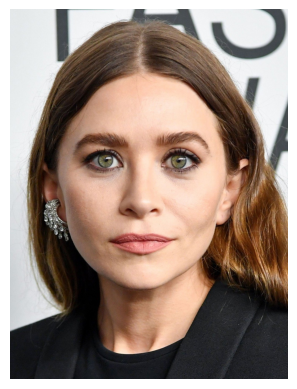

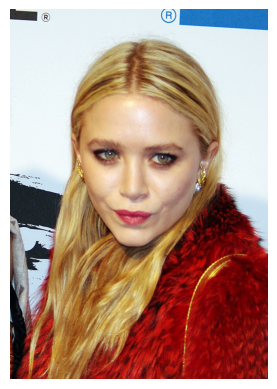

Percentage:  88
Similarities:
-  Both subjects exhibit identical ocular morphology, characterized by large, wide-set green eyes with matching canthal tilts and lid structures.
-  The nasal architecture is virtually indistinguishable, sharing the same bridge width, tip projection, and nostril flare.
-  Biometric landmarks, such as the high, prominent cheekbones and the specific length of the philtrum, show an extremely high degree of correlation.
Differences:
- Person A presents a slightly fuller, rounder face shape, whereas Person B exhibits a narrower, more elongated lower facial third and jawline.
- There is a subtle variance in the mouth; Person A's lips are relaxed and appear wider, while Person B holds tension in the mouth area (pursing), making the lips appear narrower.
- Superficial contrast in pigmentation is present, with Person A having darker eyebrows and hair roots compared to the lighter, blonde styling of Person B.


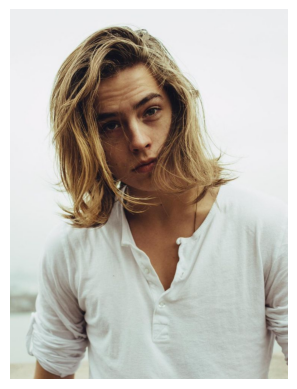

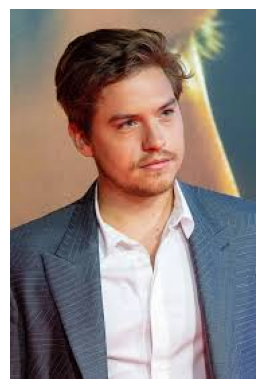

Percentage:  95
Similarities:
-  Identical bone structure and facial geometry, indicating these are the same individual or identical twins.
-  Matching eye shape, canthal tilt, and orbital depth.
-  Consistent nose structure, including the width of the bridge and the shape of the tip.
-  Identical lip morphology, specifically the Cupid's bow and the ratio of the upper to lower lip.
-  Same jawline definition and chin prominence.
-  Matching forehead height and width.
Differences:
- Hair length and styling (long and blonde in the first image vs. short and brown in the second).
- Facial hair presence (clean-shaven in the first image vs. mustache/stubble in the second).
- Minor variances in facial fullness and skin texture likely due to aging or slight weight fluctuation.
- Lighting conditions affecting the visibility of specific skin details.


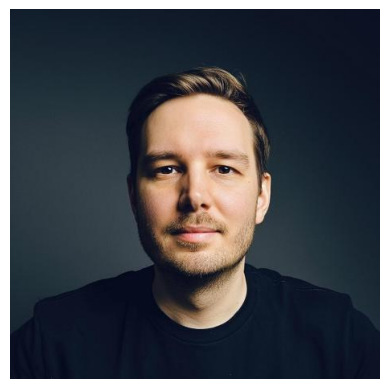

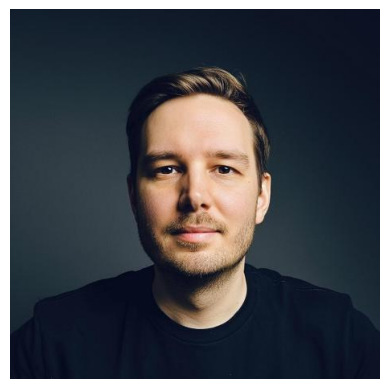

Percentage:  100
Similarities:
-  Identical facial geometry and bone structure, indicating the same biological subject.
-  Exact match in key anthropometric landmarks, including inter-pupillary distance, bizygomatic width, and mandibular shape.
-  Matching soft tissue features, such as the specific contour of the vermilion border, nasal tip projection, and ear morphology.
-  Identical dermatological details, including hair growth patterns, stubble density, and skin texture.
Differences:
- No biological or physical differences observed.
- The images appear to be identical photographs of the same individual.


In [71]:
identical_cases = [
    ['./images/Ashley_Olsen.jpg', './images/Mary_Kate_Olsen.jpg'],
    ['./images/Cole_Sprouse.jpg', './images/Dylan_Sprouse.jpg'],
    ['./images/patrick.jpg', './images/patrick.jpg']
]

print_test_cases(heading="Identical twin cases", cases=identical_cases)